<a href="https://colab.research.google.com/github/Loga19818eeanvesh/GenerativeAdversarialNetworks_GANs_Assignments/blob/main/c2w2_VariationalAutoEncoder_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    '''
    Encoder Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, output_chan=32, hidden_dim=16):
        super(Encoder, self).__init__()
        self.z_dim = output_chan
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, output_chan * 2, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a encoder block of the VAE, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''        
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Encoder: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        encoding = disc_pred.view(len(disc_pred), -1)
        # The stddev output is treated as the log of the variance of the normal 
        # distribution by convention and for numerical stability
        return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

class Decoder(nn.Module):
    '''
    Decoder Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(Decoder, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a Decoder block of the VAE, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Sigmoid(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [2]:
from torch.distributions.normal import Normal

class VAE(nn.Module):
    '''
    VAE Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=32, im_chan=1, hidden_dim=64):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encode = Encoder(im_chan, z_dim)
        self.decode = Decoder(z_dim, im_chan)

    def forward(self, images):
        '''
        Function for completing a forward pass of the Decoder: Given a noise vector, 
        returns a generated image.
        Parameters:
        images: an image tensor with dimensions (batch_size, im_chan, im_height, im_width)
        Returns:
        decoding: the autoencoded image
        q_dist: the z-distribution of the encoding
        '''
        q_mean, q_stddev = self.encode(images)
        q_dist = Normal(q_mean, q_stddev)
        z_sample = q_dist.rsample() # Sample once from each distribution, using the `rsample` notation
        decoding = self.decode(z_sample)
        return decoding, q_dist


In [3]:
reconstruction_loss = nn.BCELoss(reduction='sum')

In [4]:
from torch.distributions.kl import kl_divergence
def kl_divergence_loss(q_dist):
    return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))
    ).sum(-1)

In [6]:
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms

transform=transforms.Compose([
    transforms.ToTensor(),
])
mnist_dataset = datasets.MNIST('.', train=True, transform=transform, download=True)
train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Epoch 0


100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


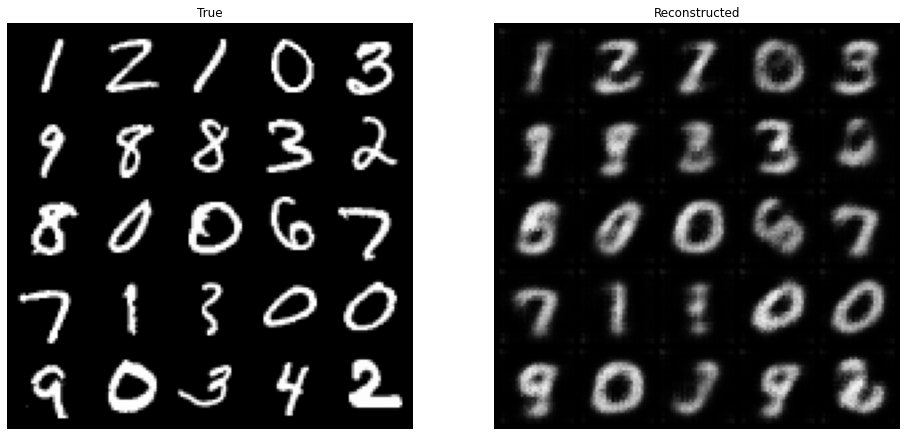

Epoch 1


100%|██████████| 59/59 [00:06<00:00,  8.96it/s]


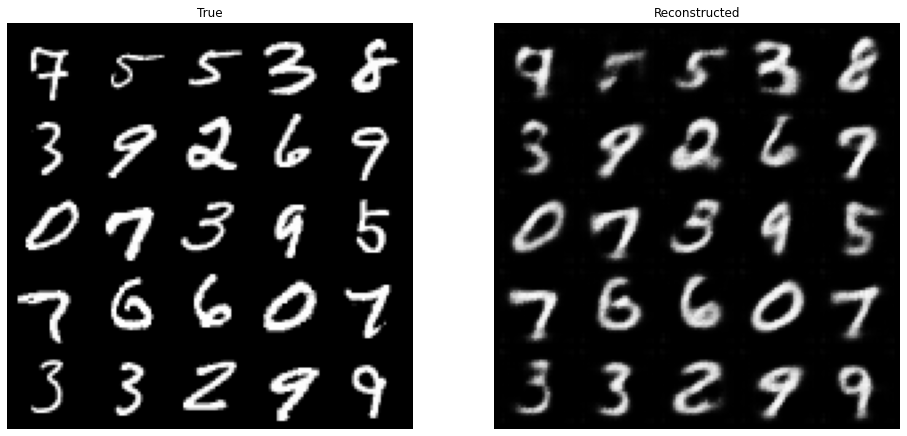

Epoch 2


100%|██████████| 59/59 [00:06<00:00,  8.89it/s]


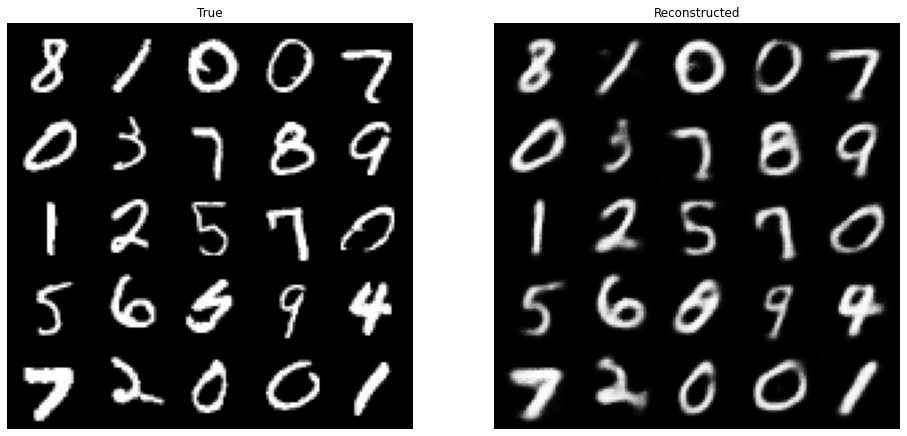

Epoch 3


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


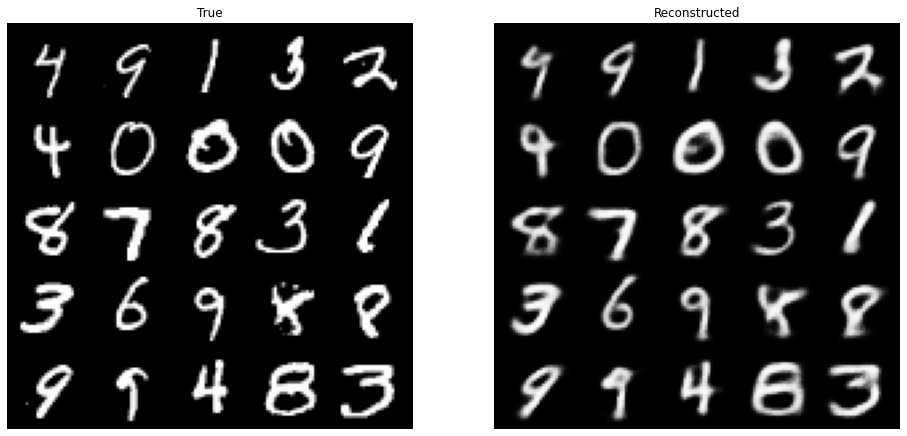

Epoch 4


100%|██████████| 59/59 [00:07<00:00,  8.19it/s]


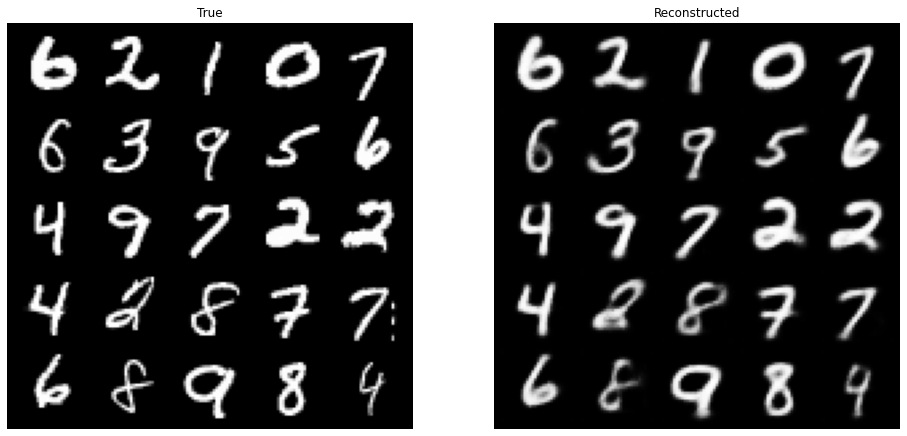

Epoch 5


100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


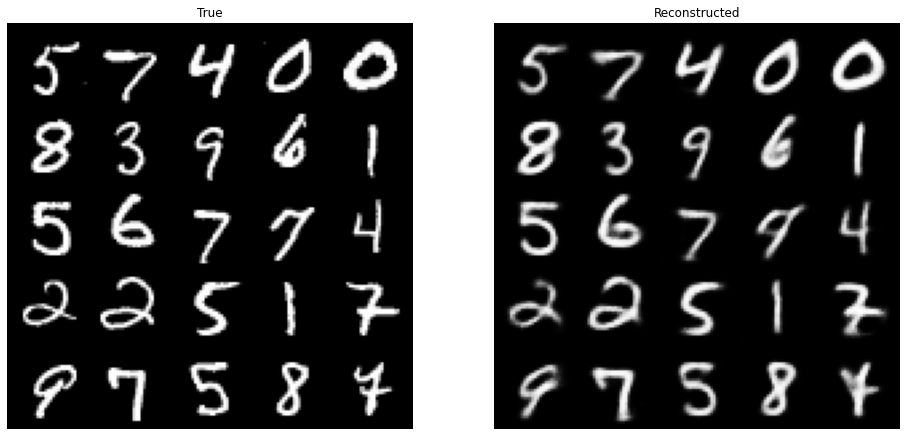

Epoch 6


100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


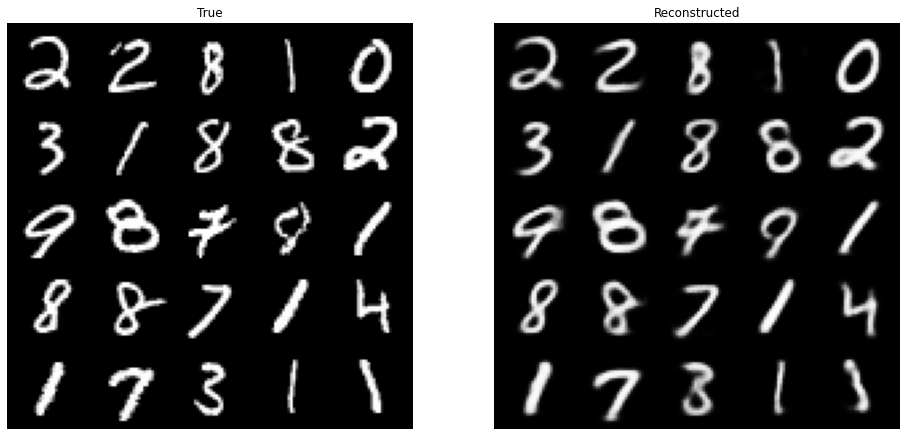

Epoch 7


100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


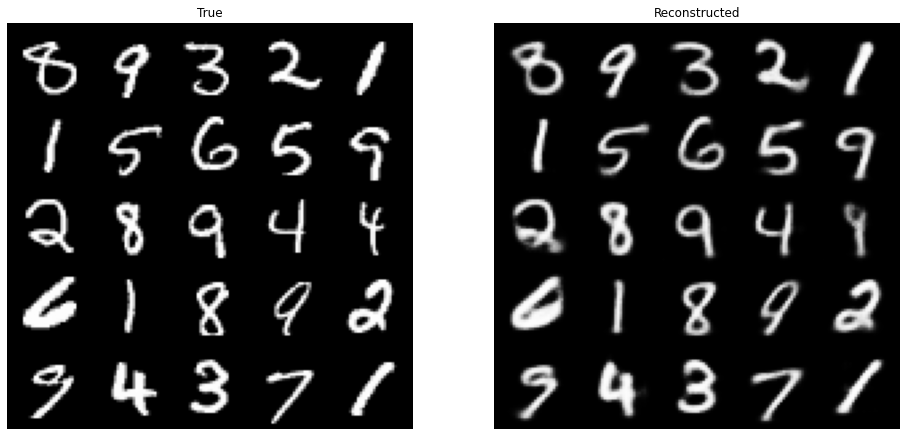

Epoch 8


100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


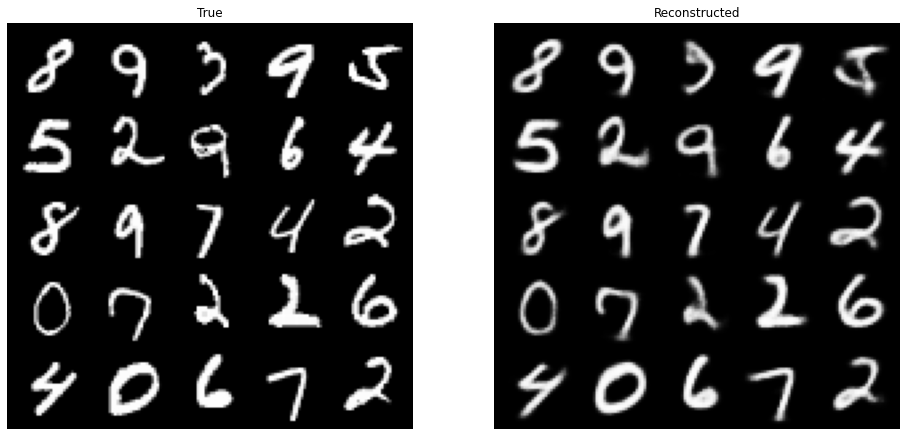

Epoch 9


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


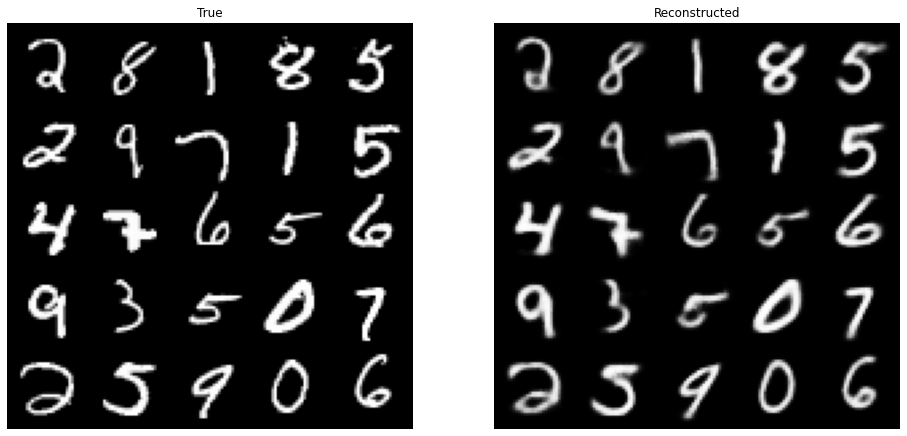

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

device = 'cuda'
vae = VAE().to(device)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)
for epoch in range(10):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    for images, _ in tqdm(train_dataloader):
        images = images.to(device)
        vae_opt.zero_grad() # Clear out the gradients
        recon_images, encoding = vae(images)
        loss = reconstruction_loss(recon_images, images) + kl_divergence_loss(encoding).sum()
        loss.backward()
        vae_opt.step()
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()